[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1DRoXJLoUVVU9RGjfb-bYQhcdhYVD-WrZ)

# Notebook #3: tweet sentiment analysis

## Description and requirements:

In this notebook, you will learn how to perform sentiments analysis on tweets extracted from Twitter in Python.

A requirement for this code to work is to have the Hedonometer.csv file downloaded from [Hedonometer](https://hedonometer.org/).

### Import modules

In [2]:
import os
import re
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

path_to_data = './data'
path_to_timelines = os.path.join(path_to_data, 'timelines')
path_to_sentiment = os.path.join(path_to_data, 'sentiment')
hedonometer_path = os.path.join(path_to_data, 'Hedonometer.csv')

os.makedirs(path_to_sentiment, exist_ok=True)

First we would like to save our work to a local file to free up memory and avoid losing our work in case of a crash. To achieve this we will define the following function:

This function will take as an input:
- `df` The DataFrame to save
- `path` The path to save the file
- `name` The name of the saved file

This function will then save the content of the `df` to a local file in `path/name` that we could read later and work on.

In [2]:
def save(df, path, name):
    df.to_pickle(os.path.join(path, f'{name}.pkl'))

Next, we would like a function that will be able to read the contents of a saved df file and load it to memory.

This function will take as an input:
- `path` The path to a folder containing all pickle files

This function will return a Pandas DataFrame containing all the files loaded

In [3]:
def load_from_pickle(path):
    # Get a list of all the files in path that end with .pkl
    files = glob(os.path.join(path, '*.pkl'))
    # Open all of them and concatenate them
    return pd.concat([pd.DataFrame(pd.read_pickle(file)) for file in files])

Now that we can load and save files, we will define a few functions:
- `sentiment` - will return the average sentiment of a sentence
- `standard_deviation` - will return the standard deviation of a sentence
- `grab_hits` - will return a list of word from the sentence that were scored

### sentiment
This function will determine the sentiment of a tweet.
It will take as an input:
- `sentence` which is the sentence (Tweet) to analyze
it then goes over all words in the sentence and searches if they appear on the Hedonometer scores ranking and averages them.

In [4]:
def sentiment(sentence):
    senti = 0
    total = 0
    words = sentence.split(" ")
    for word in words:
        if word in scores.keys():
            senti += scores[word]
            total += 1
    try:
        return senti / total
    except ZeroDivisionError:
        return 0

### standard_deviation
This function will determine the standard deviation of a tweet.

It will take as an input:
- `sentence` which is the sentence (Tweet) to analyze

it then goes over all words in the sentence and searches if they appear on the standard deviation scores ranking and averages them.

In [5]:
def standard_deviation(sentence):
    standard_deviation = 0
    total = 0
    words = sentence.split(" ")
    for word in words:
        if word in sds.keys():
            standard_deviation += sds[word]
            total += 1
    try:
        return standard_deviation / total
    except ZeroDivisionError:
        return 0

### grab_hits
This function will catch all the matched words from the tweet that appear on the hedonometer.

It will take as an input:
- `sentence` which is the sentence (Tweet) to analyze

it then goes over all words in the sentence, tries to match them with the hedonometer list, and returns the ones that were found.

In [6]:
def grab_hits(sentence):
    hits = []
    words = sentence.split(" ")
    for word in words:
        if word in sds.keys():
            hits.append(word)
    return hits

Now we would like to this for each of the tweets in our df. So we will use the `apply` method of a df.
This method will run `sentiment`, `standard_deviation`, and `grab_hits` on each of the tweets.
After running, it will convert the result to a `pandas` series and return them.

In [7]:
# Run sentiment on each tweet
def return_sentiment(df):
    return pd.Series(df["clean_text"].apply(lambda x: sentiment(x)))

# Run standard_deviation on each tweet
def return_standard_deviation(df):
    return pd.Series(df["clean_text"].apply(lambda x: standard_deviation(x)))

# Run grab_hits on each tweet
def return_hits(df):
    return pd.Series(df["clean_text"].apply(lambda x: grab_hits(x)))

Since the tweets can be in different languages we will use the translation method that we covered in [Notebook #2: machine translation](2-machine-translation.ipynb).


In [8]:
import transformers
from transformers import MarianMTModel, MarianTokenizer
from transformers.hf_api import HfApi

In [9]:
transformers.__version__

'4.0.1'

In [10]:
class Translator:

    def __init__(self, src_language, tgt_language):
        self.src_language = src_language
        self.tgt_language = tgt_language
        self.model_name = f'Helsinki-NLP/opus-mt-{src_language}-{tgt_language}'
        model_list = HfApi().model_list()
        org = "Helsinki-NLP"
        self.valid_model_names = [x.modelId for x in model_list if x.modelId.startswith(org)]
        if self.model_name not in self.valid_model_names:
            raise KeyError(f'{self.model_name} is not a valid model name.')

    def load_model(self):
        """Load translation model and tokenizer."""
        tokenizer = MarianTokenizer.from_pretrained(self.model_name)
        model = MarianMTModel.from_pretrained(self.model_name)
        return tokenizer, model

    def translate(self, src_text, loaded_model):
        """Use loaded model and tokenizer to translate the source text."""
        tokenizer, model = loaded_model
        translated = model.generate(**tokenizer.prepare_seq2seq_batch([src_text], return_tensors="pt"))
        return [tokenizer.decode(t, skip_special_tokens=True) for t in translated][0]

Now, we load our Translator model, and we will simply run:

In [11]:
translator = Translator('ur', 'en')
model = translator.load_model()

In order to clean our tweets from url's, prefixes and more we will define the following functions:
- `remove_pattern` - this function will remove a given pattern from an input text
- `remove_prefix` - this function will remove a given prefix from an input text
- `clean_and_translate` - this function will use the above methods and more to clean an entire df of tweets

### remove_pattern
This function will remove a given pattern from the text using regular expression

It will take as an input:
- `input_txt` The input text to remove
- `pattern` The pattern to remove

And will returned the clean text

In [12]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

### remove_prefix
This function will remove a prefix from a given text

It will receive as an input:
- `text` The text to remove the prefix from
- `prefix` The prefix to remove

And will returned the clean text

In [13]:
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        text = text.replace(prefix, "", 1)
    return text

### clean_and_translate
It will clean the tweets from the df using the above functions
This function will receive:
- `df` the DataFrame containing all the tweets

It will create a new column called `clean_text` in the df that will contain all the clean and translated tweets

In [14]:
def clean_and_translate(df):
    # Remove all url's from the tweet
    df['clean_text'] = df['full_text'].str.replace('http\S+|www.\S+', '', case=False)
    # Remove all \n from text
    df['clean_text'] = np.vectorize(remove_pattern)(df['clean_text'], "\n")
    # Remove all @ tags
    df['clean_text'] = np.vectorize(remove_pattern)(df['clean_text'], "@[\w]*")
    # Remove all RT prefix
    df['clean_text'] = df['clean_text'].progress_apply(lambda x: remove_prefix(x, "RT : "))
    #remove all # tags
    df['clean_text'] = np.vectorize(remove_pattern)(df['clean_text'], r"#(\w+)")
    # Remove all # from it
    df['clean_text'] = df['clean_text'].str.replace('#', '')
    # Make the string lower case
    df['clean_text'] = df['clean_text'].str.lower()
    # remove all the punctuation
    df['clean_text'] = df.clean_text.str.replace(r'[^\w\s]', '')
    # If some tweets were left empty then remove them
    df = df[df['clean_text'] != '']
    # Translate the tweets and return the DataFrame
    df['clean_text'] = df['clean_text'].progress_apply(lambda text: translator.translate(text, model))
    return df

Finally, we can load our Hedonometer and start calculating the sentiments of the tweets.
First, we will load the Hedonometer scores and create a dictionary of them. Each entry will be in the form of {key: value}, where `key` stand for a word from the list and `value` will be the sentiment score given to it.

In [15]:
file = pd.read_csv(hedonometer_path)
scores = file[["Word", "Happiness Score"]]
scores.columns = ["word", "score"]
scores = dict(zip(scores.word, scores.score))

Second, we will load of the deviation scores to `sds`.
Again, we will create a dictionary where each entry will be in the form of {key: value}, where `key` stand for a word from the list and `value` will be the standard deviation given to it.
Using the same file we create a dictionary of words and standard deviations of scores

In [16]:
sds = file[["Word", "Standard Deviation of Ratings"]]
sds.columns = ["word", "deviation"]
sds = dict(zip(sds.word, sds.deviation))

Now, let's run an example on the downloaded timelines from [Notebook #1: tweet extraction from the Twitter API](1-download-from-twitter-api.ipynb)

In [17]:
# Open all Urdu translated tweets from timeline
df = load_from_pickle(path_to_timelines)
print(df['full_text'].head())
# Clean input and translate if needed
df = clean_and_translate(df)
print(df['clean_text'].head())
# Run the hedonometer on the tweets
df["hedonometer"] = return_sentiment(df)
# Clear all tweets with no score
df = df[df["hedonometer"] != 0]
# Calculate the standard deviation for each tweets sentiment
df["hedo_sd"] = return_standard_deviation(df)
# Run function to pull the words from each tweet that determine sentiment into a new column
df["hits"] = return_hits(df)
# Save tweets with sentiments
save(df, path_to_sentiment, 'sentiment')

100%|██████████| 2570/2570 [26:51<00:00,  1.59it/s]  
e:\workspace\python\python troject\venv\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 1164/1164 [00:00<00:00, 116706.19it/s]


0    @MuradSaeedPTI بارش درجن آلو سے نکل کر دیکھو نامراد صاحب کیوں کہ ہم آپ کو اقتدار میں اس لیئے لائے کہ ہماری امیدیں وابستہ تھی کہ شاہد یہ ماں کا لال ہمارے ملک کو قرضوں سے نجات دلائے گا اس ماں کے لال نے 30 ہزار ارب قرضے میں سے 10 ہزار ارب کی قسط واپس کی اور ابھی قرضہ 43 ہزار ارب رہ چکا ھے.
1    پلٹ کر جواب دینا بیشک غلط ھے لیکن سنتے رہو تو لوگ بولنے کی تمیز بھول جاتے ہیں.🤔 شب بخیر..😍                                                                                                                                                                                                     
2    @Anosha11593895 زبان پر قابو رکھنا مشکل ضرور ھے مگر ناممکن نہیں، ضبط اور برداشت اکثر شرمندگی سے بچا لیتے ہیں، کیونکہ کئی دفعہ منہ سے نکلے الفاظ معذرت اور معافی کے باوجود شخصیت کو ناقابل تلافی نقصان پہنچا دیتے ہیں.                                                                          
3    Silence Is the best Answer of All stupids Questions.🤫🤫\nAnd a Smile is the best Reaction in All critical situations.

### Let us define some more function that will help to plot our results:

This function will calculate the mean sentiment of a DataFrame based on a given frequency.

This function will receive:
- `df` A DataFrame of the tweets
- `freq` A frequency of the tweets, default value is daily. For more information about this please visit [time-date-components](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components)
- `start_date` Start date for the tweets, default value is `2020-01-01`
- `end_date` End date for the tweets, default value is `2021-01-01`

This function will calculate the mean sentiment of given frequency tweets of starting from the `date`

In [18]:
def get_mean_based_on_frequency(df, freq, start_date='2020-01-01', end_date='2021-01-01'):
    df["created_at"] = pd.to_datetime(df['created_at'])
    df = df.set_index("created_at")
    df = df[['hedonometer']]
    return df.resample(freq).mean()[start_date:end_date]

We will need the final function to plot the sentiment and save it in a PDF file for future use:

This function will take as an input:
- `df` The DataFrame to plot and save
- `ylabel` The label of the Y axis
- `xlabel` The label for the X axis
- `title` The plot title that will be used to save the PDF

In [19]:
def plot_save_to_pdf_and_show(df, ylabel, xlabel, title):
    axes = df.plot(marker='', alpha=1, linestyle='-', figsize=(25, 10), subplots=False, legend=True)
    axes.set_ylabel(ylabel, fontsize=14)
    axes.set_xlabel(xlabel, )
    axes.set_title(title, fontsize=22, pad=20)
    axes.tick_params(axis='both', which='major', labelsize=14)
    axes.legend(fontsize=14)
    # plt.ylim(4.5, 6.5)
    plt.savefig(f'{title}', dpi=300, bbox_inches="tight",
                transparent=True)
    plt.show()

Now we are finally ready to plot out results
We will plot the mean of off users that tweeted as well as the top 4 users
In order to achieve that we will need to do some work:

In [38]:
# Get only the user_id, the time the tweet was created and the hedonometer score
sent_df = df[["user", "created_at", "hedonometer", 'clean_text']]
sent_df['name'] = sent_df['user'].apply(lambda user: user['name'])
sent_df = sent_df.drop(columns=['user'])
# Split them to different DataFrames, this will sort the DataFrame by the 'user_id' and sort them
split_df = sorted([pd.DataFrame(y) for x, y in sent_df.groupby('name', as_index=False)], key=len, reverse=True)
print(f"There are {len(split_df)} different users\n"
      f"The user with most tweets is: {split_df[0].iloc[0]['name']} with {len(split_df[0])} tweets\n"
      f"The user with the least tweets is: {split_df[-1].iloc[0]['name']} with {len(split_df[-1])} tweets")
# Show the last tweet of the user
print(f'the last tweet of the user: {split_df[0].clean_text[:1]}')

There are 21 different users
The user with most tweets is: itz_mirza_obaid with 620 tweets
The user with the least tweets is: Waqar Ahmed with 1 tweets
the last tweet of the user: 7    The only ones to enjoy God’s mercy.
Name: clean_text, dtype: object


e:\workspace\python\python troject\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We can see that this tweet is really negative, so we expect to see the score really low

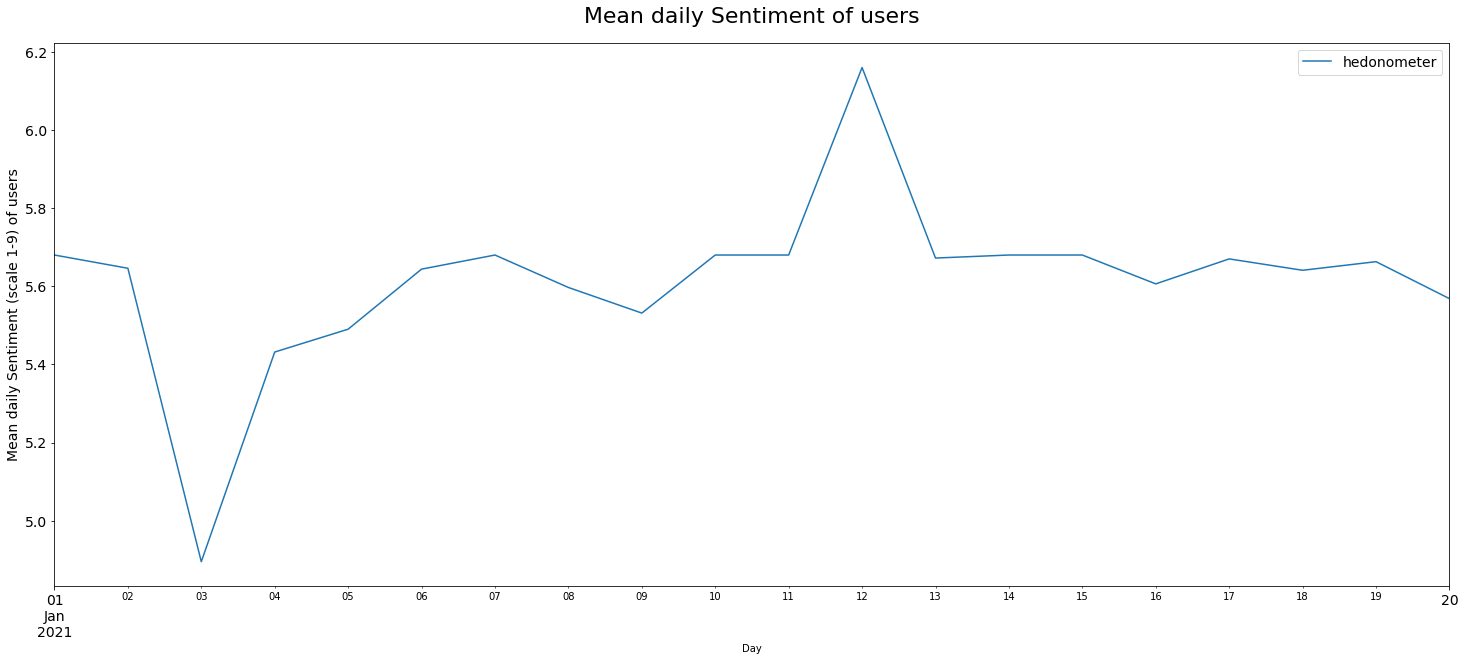

In [27]:
# Take the top user
split_df = split_df[:1]
# get the id's of the users
user_names = [sdf.iloc[0]['name'] for sdf in split_df]
# Get Daily Mean of each user
split_df = [get_mean_based_on_frequency(sf, start_date='2018-10-01',end_date='2019-01-07', freq='D') for sf in split_df]
# combine the users, each to its own column
split_sentiment = pd.concat(split_df, axis=1)
# Rename the columns
split_sentiment.columns = user_names
# Get Overall daily mean of the tweets
user_sentiment = get_mean_based_on_frequency(sent_df, start_date='2021-01-01', end_date='2021-01-20', freq='D')
# Plot Over all daily sentiment and save it
plot_save_to_pdf_and_show(df=user_sentiment, ylabel='Mean daily Sentiment (scale 1-9) of users', xlabel='Day',
                          title='Mean daily Sentiment of users')

This figure shows the average daily sentiment of users from August to December.
We can see from the figure that on average the sentiment is from 4.8 to 6.2 which is on the positive side.

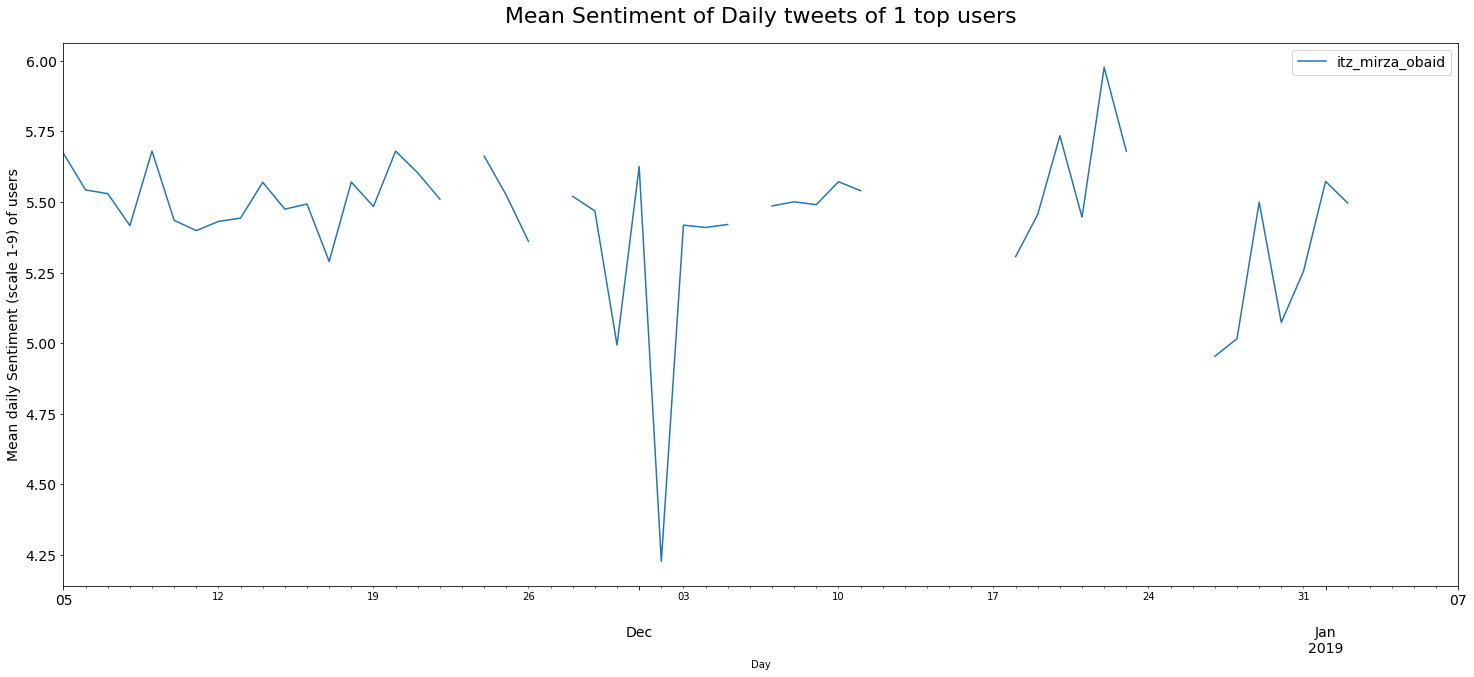

In [28]:
# Plot Key users daily sentiment and save it
plot_save_to_pdf_and_show(df=split_sentiment, ylabel='Mean daily Sentiment (scale 1-9) of users', xlabel='Day',
                          title=f"Mean Sentiment of Daily tweets of {len(user_names)} top users")

We can see that the user is rather positive, except for a few tweets that had their content really negative.
The lowest of them all simply translated to: "I'll kill you." on Dec. 2nd which as you can guess, quite negative.
His most positive message on the 22nd of Dec. which read: "while still a few years ago, you're going to have a lot of money."